/var/folders/c2/82qvf75162b67vqy5scm8x_r0000gn/T/ipykernel_99282/1338835173.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, audio = read("input2.wav")


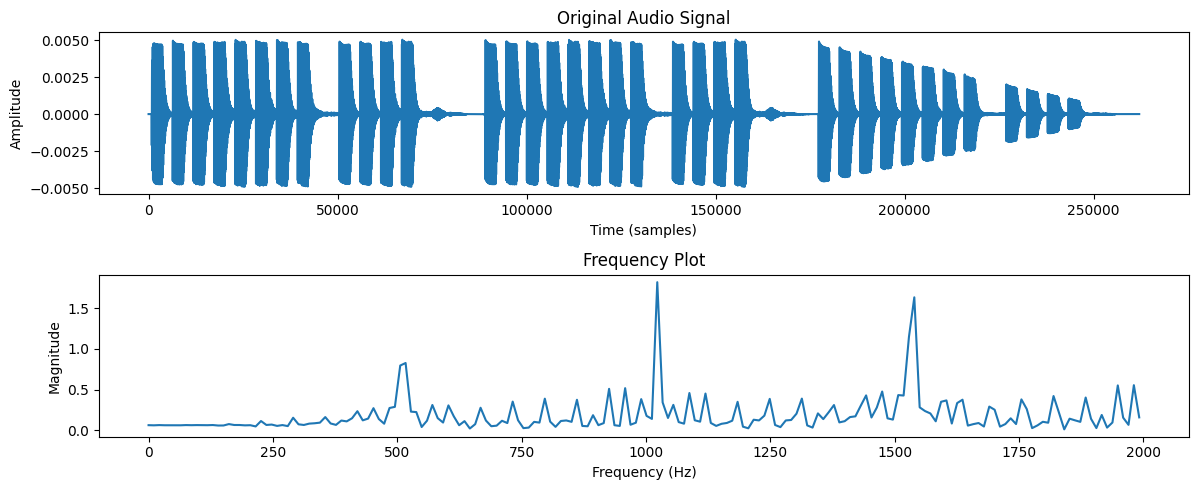

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io.wavfile import read, write
from scipy.fftpack import fft, ifft
from scipy.interpolate import interp1d
from qiskit.primitives import Sampler, Estimator

sample_rate, audio = read("input2.wav")

# Convert to mono if stereo
if len(audio.shape) > 1:
    audio = audio[:, 0]


#manually add noise

# noise_intensity = 5000  
# noise = np.random.normal(0, noise_intensity, audio.shape)

# noisy_audio = np.int16(audio + noise)

# write("noisy_audio.wav", sample_rate, noisy_audio)


N = len(audio)
target_samples = 2**12
audio_segment = audio

audio_segment = audio_segment/np.linalg.norm(audio_segment)
fft_result = fft(audio_segment)
frequencies = np.fft.fftfreq(target_samples, d=1/sample_rate)

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(audio_segment)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Original Audio Signal")

max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.subplot(2, 1, 2)
plt.plot(frequencies[indices], np.abs(fft_result[indices]))  
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Plot")
plt.tight_layout()
plt.show()


20984.1064453125
21177.9052734375
21242.5048828125
21759.3017578125
21823.9013671875
21942.333984375
21953.1005859375
22006.93359375
22017.7001953125
22039.2333984375
-22028.466796875
-22017.7001953125
-21996.1669921875
-21920.80078125
-21899.267578125
-21888.5009765625
-21856.201171875
-21834.66796875
-21823.9013671875
-21802.3681640625
-21770.068359375
-21759.3017578125
-21737.7685546875
-21705.46875
-21673.1689453125
-21662.40234375
-21640.869140625
-21587.0361328125
-21576.26953125
-21565.5029296875
-21511.669921875
-21393.2373046875
-21382.470703125
-21328.6376953125
-21317.87109375
-21253.271484375
-12747.65625
-12618.45703125
-11089.599609375
-11078.8330078125
-10960.400390625
-10949.6337890625
-10928.1005859375
-10852.734375
-10831.201171875
-10820.4345703125
-10798.9013671875
-10723.53515625
-10702.001953125
-10691.2353515625
-10669.7021484375
-10637.40234375
-10594.3359375
-10572.802734375
-10562.0361328125
-10540.5029296875
-10508.203125
-10465.13671875
-10443.603515625
-104

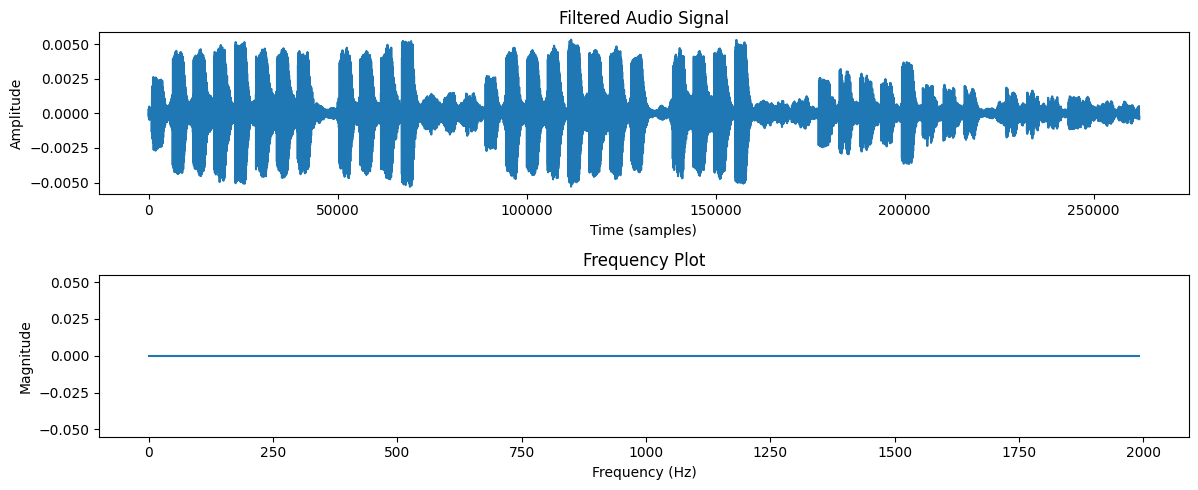

In [3]:
for i in range (0,target_samples):
    if np.abs(fft_result[i]) < 15:
        fft_result[i] = 0
    else:
        print(frequencies[i])


new_res = ifft(fft_result).real


plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(new_res)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Filtered Audio Signal")

max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.subplot(2, 1, 2)
plt.plot(frequencies[indices], np.abs(fft_result[indices]))  
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Plot")
plt.tight_layout()
plt.show()



In [4]:
filtered_audio = np.int16(ifft(fft_result).real) 

output_filename = "filtered_audio.wav"
write(output_filename, sample_rate, filtered_audio)

In [25]:
fft_result = fft(filtered_audio)
frequencies = np.fft.fftfreq(target_samples, d=1/sample_rate)

# Retune ratio (A440 to A415)
retune_ratio = 1/2 #double the frequencies

# New frequency bins after shifting
shifted_frequencies = frequencies * retune_ratio

# Interpolate FFT result to match new frequency bins
interp_func = interp1d(frequencies, fft_result, kind='linear', fill_value=0, bounds_error=False)
shifted_fft_result = interp_func(shifted_frequencies)


for i in range (0,target_samples):
    if np.abs(shifted_fft_result[i]) < 1000:
        shifted_fft_result[i] = 0


retuned_audio = np.int16(ifft(shifted_fft_result).real)


output_filename = "retuned_audio.wav"
write(output_filename, sample_rate, retuned_audio)

NameError: name 'filtered_audio' is not defined

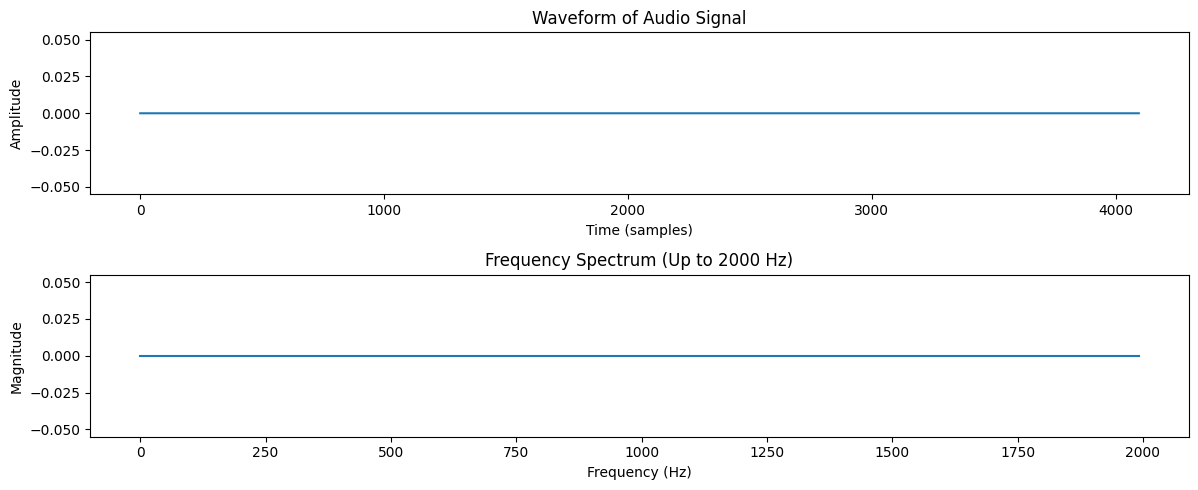

In [ ]:
max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.figure(figsize=(12, 5))
plt.subplot(2, 1, 1)
plt.plot(retuned_audio)
plt.xlabel("Time (samples)")
plt.ylabel("Amplitude")
plt.title("Audio Signal")

max_freq = 2000
indices = np.where(frequencies >= 0)[0]  
indices = indices[frequencies[indices] <= max_freq]  

plt.subplot(2, 1, 2)
plt.plot(frequencies[indices], np.abs(shifted_fft_result[indices]))  
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("Frequency Plot")
plt.tight_layout()
plt.show()


In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import numpy as np
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator, Aer, aer_simulator

def load_and_normalize_audio(filename):
    """Load an audio file and keep only the first 1024 samples (2^10)."""
    sample_rate, audio = read(filename)

    # Convert to mono if stereo
    if len(audio.shape) > 1:
        audio = audio[:, 0]
    
    # Keep only the first 1024 samples
    target_samples = 2**13
    audio = audio[:target_samples]  # Truncate without padding

    print(f"Audio truncated to {target_samples} samples for 10 qubits.")

    # Normalize the audio for quantum state preparation
    norm_factor = np.linalg.norm(audio)
    normalized_audio = audio / norm_factor
    
    return sample_rate, normalized_audio, norm_factor, 13

def prepare_quantum_state(normalized_audio, n_qubits):
    """Prepare a quantum state from normalized audio data."""
    qc = QuantumCircuit(n_qubits)

    # Initialize the quantum state with the normalized audio data
    qc.initialize(normalized_audio, range(n_qubits))
    n_samples = len(normalized_audio)
    print(n_samples)
    return qc

In [ ]:


def denoise_oracle(statevector, threshold=0.05):

    probabilities = np.abs(statevector.data) ** 2

    for i in range (0,2**n_qubits):
        if probabilities[i] < threshold:
            statevector.data[i] = 0
        else:
            print(i)
    
    norm_factor2 = np.linalg.norm(statevector.data)

    normalized_denoise = statevector.data/norm_factor2

    denoised_state = prepare_quantum_state(normalized_denoise, n_qubits)
    

    return denoised_state

audio_file = "noisy_audio.wav"

# Load and normalize audio data
sample_rate, normalized_audio, norm_factor, n_qubits = load_and_normalize_audio(audio_file)

qc = prepare_quantum_state(normalized_audio, n_qubits)

qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))


# Get state after QFT
state = Statevector(qc)  

# Apply oracle to denoise the signal
qc = qc.compose((denoise_oracle(state)))

# Inverse QFT to return to time domain
qc = qc.compose(QFT(n_qubits, do_swaps=True, inverse=True), range(n_qubits))

# "Measure" the statevector
backend = Aer.get_backend('statevector_simulator')
qc = transpile(qc, backend)

state = Statevector(qc)  



Audio truncated to 8192 samples for 10 qubits.
8192
82
8110
8192


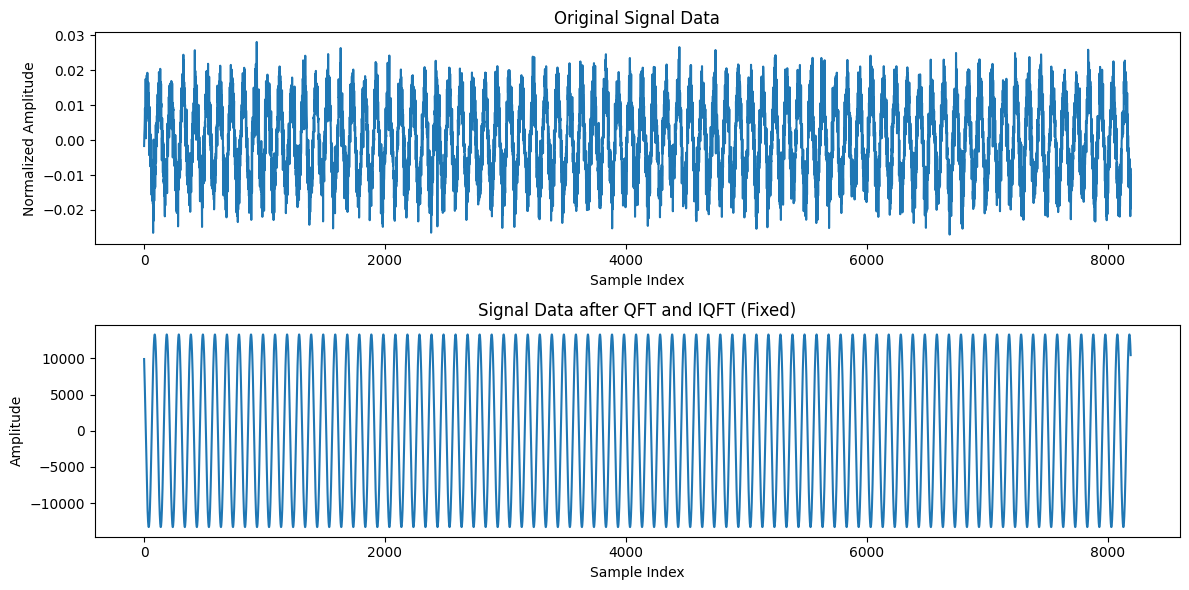

In [ ]:
retrieved_audio = (state.data.real)

retrieved_audio = retrieved_audio * norm_factor  

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(range(2**n_qubits), normalized_audio)
plt.title("Original Audio Signal")
plt.xlabel("Sample Index")
plt.ylabel("Normalized Amplitude")

plt.subplot(2, 1, 2)
plt.plot(range(2**n_qubits), retrieved_audio)
plt.title("Filtered Audio Signal")
plt.xlabel("Sample Index")
plt.ylabel("Amplitude")

plt.tight_layout()
plt.show()

In [ ]:
filtered_audio = np.int16(retrieved_audio) 

output_filename = "quantum_filtered.wav"
write(output_filename, sample_rate, filtered_audio)

In [ ]:
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit.quantum_info import Statevector
import numpy as np
from scipy.io.wavfile import read, write
import matplotlib.pyplot as plt
from qiskit.circuit.library import QFT
from qiskit_aer import AerSimulator, Aer, aer_simulator

def load_audio(filename):
    """Load an audio file and return the sample rate and audio data."""
    sample_rate, audio = read(filename)
    # Convert to mono if stereo
    if len(audio.shape) > 1:
        audio = audio[:, 0]
    return sample_rate, audio

def process_audio_chunk(audio_chunk, n_qubits=13, threshold=0.05):
    """Process a chunk of audio data using quantum circuit."""
    # Normalize the audio for quantum state preparation
    norm_factor = np.linalg.norm(audio_chunk)
    
    # Handle the case where the chunk might be all zeros
    if norm_factor < 1e-10:  # Effectively zero
        print("Warning: Audio chunk contains all zeros or very small values")
        # Return zeros for this chunk
        return np.zeros(len(audio_chunk))
        
    normalized_audio = audio_chunk / norm_factor
    
    # Prepare quantum state
    qc = prepare_quantum_state(normalized_audio, n_qubits)
    
    # Apply QFT
    qc.append(QFT(n_qubits, do_swaps=True), range(n_qubits))
    
    # Get state after QFT
    state = Statevector(qc)
    
    # Apply oracle to denoise the signal
    qc = qc.compose((denoise_oracle(state, n_qubits, threshold)))
    
    # Inverse QFT to return to time domain
    qc = qc.compose(QFT(n_qubits, do_swaps=True, inverse=True), range(n_qubits))
    
    # "Measure" the statevector
    backend = Aer.get_backend('statevector_simulator')
    qc = transpile(qc, backend)
    state = Statevector(qc)
    
    # Denormalize the processed audio
    processed_chunk = state.data.real * norm_factor
    
    return processed_chunk

def prepare_quantum_state(normalized_audio, n_qubits):
    """Prepare a quantum state from normalized audio data."""
    qc = QuantumCircuit(n_qubits)
    # Initialize the quantum state with the normalized audio data
    qc.initialize(normalized_audio, range(n_qubits))
    return qc

def denoise_oracle(statevector, n_qubits, threshold=0.05):
    """Apply denoising to the quantum state."""
    # Get data from statevector (we can't modify it directly)
    sv_data = statevector.data.copy()  # Make a copy we can modify
    probabilities = np.abs(sv_data) ** 2
    
    # Apply thresholding to our copy
    for i in range(0, 2**n_qubits):
        if probabilities[i] < threshold:
            sv_data[i] = 0
    
    # Check if we removed all values or if norm is too small
    norm_factor2 = np.linalg.norm(sv_data)
    
    if norm_factor2 < 1e-10:  # Effectively zero
        # If all values were removed or norm is too small, keep the strongest component
        max_idx = np.argmax(probabilities)
        sv_data = np.zeros_like(sv_data)
        sv_data[max_idx] = 1.0
        normalized_denoise = sv_data
    else:
        normalized_denoise = sv_data / norm_factor2
    
    denoised_state = prepare_quantum_state(normalized_denoise, n_qubits)
    return denoised_state

def process_full_audio(full_audio, sample_rate, threshold=0.05, overlap=0.1):
    """Process audio data in chunks of 2^13 samples with overlap."""
    # Define chunk size (2^13)
    chunk_size = 2**13
    n_qubits = 13
    
    # Calculate overlap in samples
    overlap_samples = int(chunk_size * overlap)
    
    # Calculate number of chunks with overlap
    total_samples = len(full_audio)
    # Adjust calculation for overlapping chunks
    num_chunks = (total_samples - overlap_samples + chunk_size - 1) // (chunk_size - overlap_samples)
    
    print(f"Processing {total_samples} samples in {num_chunks} chunks of {chunk_size} samples each (with {overlap_samples} sample overlap)")
    
    # Initialize array for processed audio and overlap weights
    processed_audio = np.zeros(total_samples, dtype=np.float64)  # Use float64 for accumulation
    overlap_weights = np.zeros(total_samples, dtype=np.float64)
    
    # Process each chunk
    for i in range(num_chunks):
        # Calculate start and end indices with overlap
        start_idx = i * (chunk_size - overlap_samples)
        end_idx = min(start_idx + chunk_size, total_samples)
        
        # Get current chunk
        current_chunk = full_audio[start_idx:end_idx]
        
        # If the last chunk is smaller than chunk_size, pad with zeros
        if len(current_chunk) < chunk_size:
            padded_chunk = np.zeros(chunk_size, dtype=full_audio.dtype)
            padded_chunk[:len(current_chunk)] = current_chunk
            current_chunk = padded_chunk
            
        print(f"Processing chunk {i+1}/{num_chunks}: samples {start_idx} to {end_idx-1}")
        
        try:
            # Process the chunk
            processed_chunk = process_audio_chunk(current_chunk, n_qubits, threshold)
        except Exception as e:
            print(f"Error processing chunk {i+1}: {str(e)}")
            # If processing fails, use the original chunk
            processed_chunk = current_chunk
        
        # If it was a padded chunk, only take the valid part
        valid_samples = min(chunk_size, end_idx - start_idx)
        
        # Create a crossfade weight window (triangular for simplicity)
        window = np.hanning(valid_samples)
        if i > 0 and overlap_samples > 0:  # Apply fade-in for non-first chunks
            fade_in = np.linspace(0, 1, min(overlap_samples, valid_samples))
            window[:len(fade_in)] = fade_in
        
        if i < num_chunks - 1 and end_idx < total_samples:  # Apply fade-out for non-last chunks
            fade_out = np.linspace(1, 0, min(overlap_samples, valid_samples - max(0, valid_samples - overlap_samples)))
            window[-len(fade_out):] = fade_out
        
        # Apply window and accumulate
        processed_audio[start_idx:start_idx + valid_samples] += processed_chunk[:valid_samples].real * window
        overlap_weights[start_idx:start_idx + valid_samples] += window
    
    # Normalize by the overlap weights to get the final audio
    # Avoid division by zero
    mask = overlap_weights > 0
    processed_audio[mask] /= overlap_weights[mask]
    
    return processed_audio

# Main execution
if __name__ == "__main__":
    audio_file = "noisy_audio.wav"
    threshold = 0.05  # Adjust as needed
    overlap = 0.50  # 50% overlap between chunks
    
    # Load the original audio directly in the main function
    sample_rate, original_audio = load_audio(audio_file)
    
    # Process the audio file
    processed_audio = process_full_audio(original_audio, sample_rate, threshold, overlap)
    
    # Save the processed audio - ensure we're using the original sample rate and data type
    original_dtype = original_audio.dtype
    if np.issubdtype(original_dtype, np.integer):
        # For integer types, scale appropriately to avoid clipping
        processed_audio = np.clip(processed_audio, np.iinfo(original_dtype).min, np.iinfo(original_dtype).max)
    
    write("processed_audio.wav", sample_rate, processed_audio.astype(original_dtype))
    
    # Plot original and processed audio (optional)
    plt.figure(figsize=(12, 6))
    
    plt.subplot(2, 1, 1)
    plt.title("Original Audio")
    plt.plot(original_audio[:min(10000, len(original_audio))])
    
    plt.subplot(2, 1, 2)
    plt.title("Processed Audio")
    plt.plot(processed_audio[:min(10000, len(processed_audio))])
    
    plt.tight_layout()
    plt.savefig("audio_comparison.png")
    plt.show()

Processing 88200 samples in 22 chunks of 8192 samples each (with 4096 sample overlap)
Processing chunk 1/22: samples 0 to 8191
Processing chunk 2/22: samples 4096 to 12287
